Objective - Generate Kindney Segmentation Masks in an unsupervised manner. 

Approach:
- Kidney segmentation is a solved problem, and easiest way to do this would be to train a unet based model on any available dataset using frameworks such as Monai.
- As I have been exploring PaliGemma which is the recent release from Google in the visionllm space, and its also commercial firendly, we will use that for our foundation model. 
- We will also explore other MV based techniques for this problem. 

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
# %matplotlib inlinepython

In [2]:
import os 
os.chdir("..")
os.getcwd()

'/mnt/ai-storage/personal/pradip/diffusion'

In [3]:
os.environ['HF_HOME'] = './data'

In [4]:
import cv2
import matplotlib.pyplot as plt
import re
import numpy as np
from PIL import Image
import copy

# Load sample frames

In [5]:
root_dir = './data/kidney_stones/train/images/'

In [6]:
images_list = os.listdir(root_dir)

In [9]:
images_list[170], len(images_list)

('1-3-46-670589-33-1-63713387526867796200001-5298413226642151631_png_jpg.rf.8fe3cfb9670bbf9947f2c41df49e32f1.jpg',
 1054)

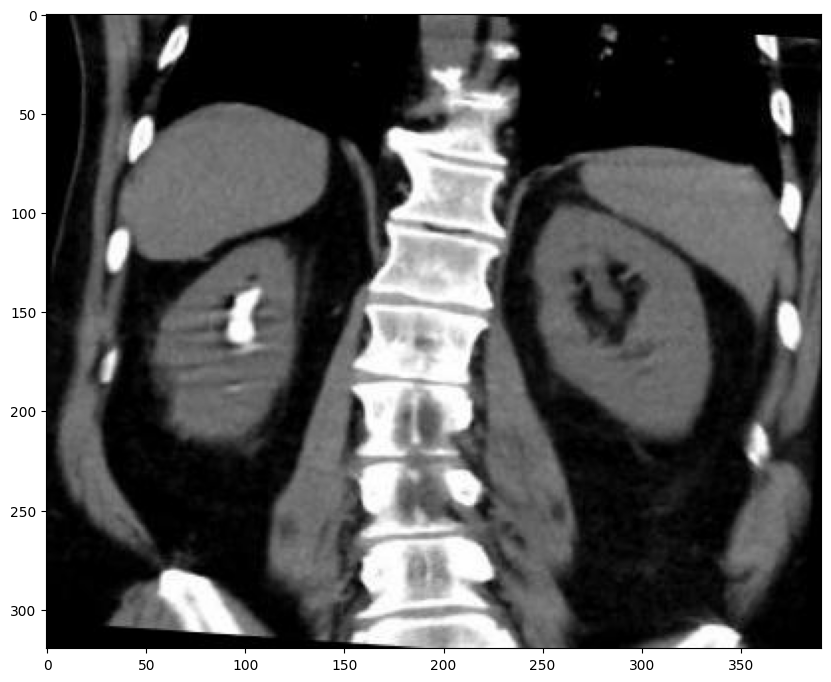

In [7]:
sample_image = cv2.imread(os.path.join(root_dir, 
                                       images_list[270]))
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB) 
plt.figure(figsize=(10,10))
plt.imshow(sample_image)

In [11]:
sample_image.shape

(320, 391, 3)

# Kidney segmentation using foundation models

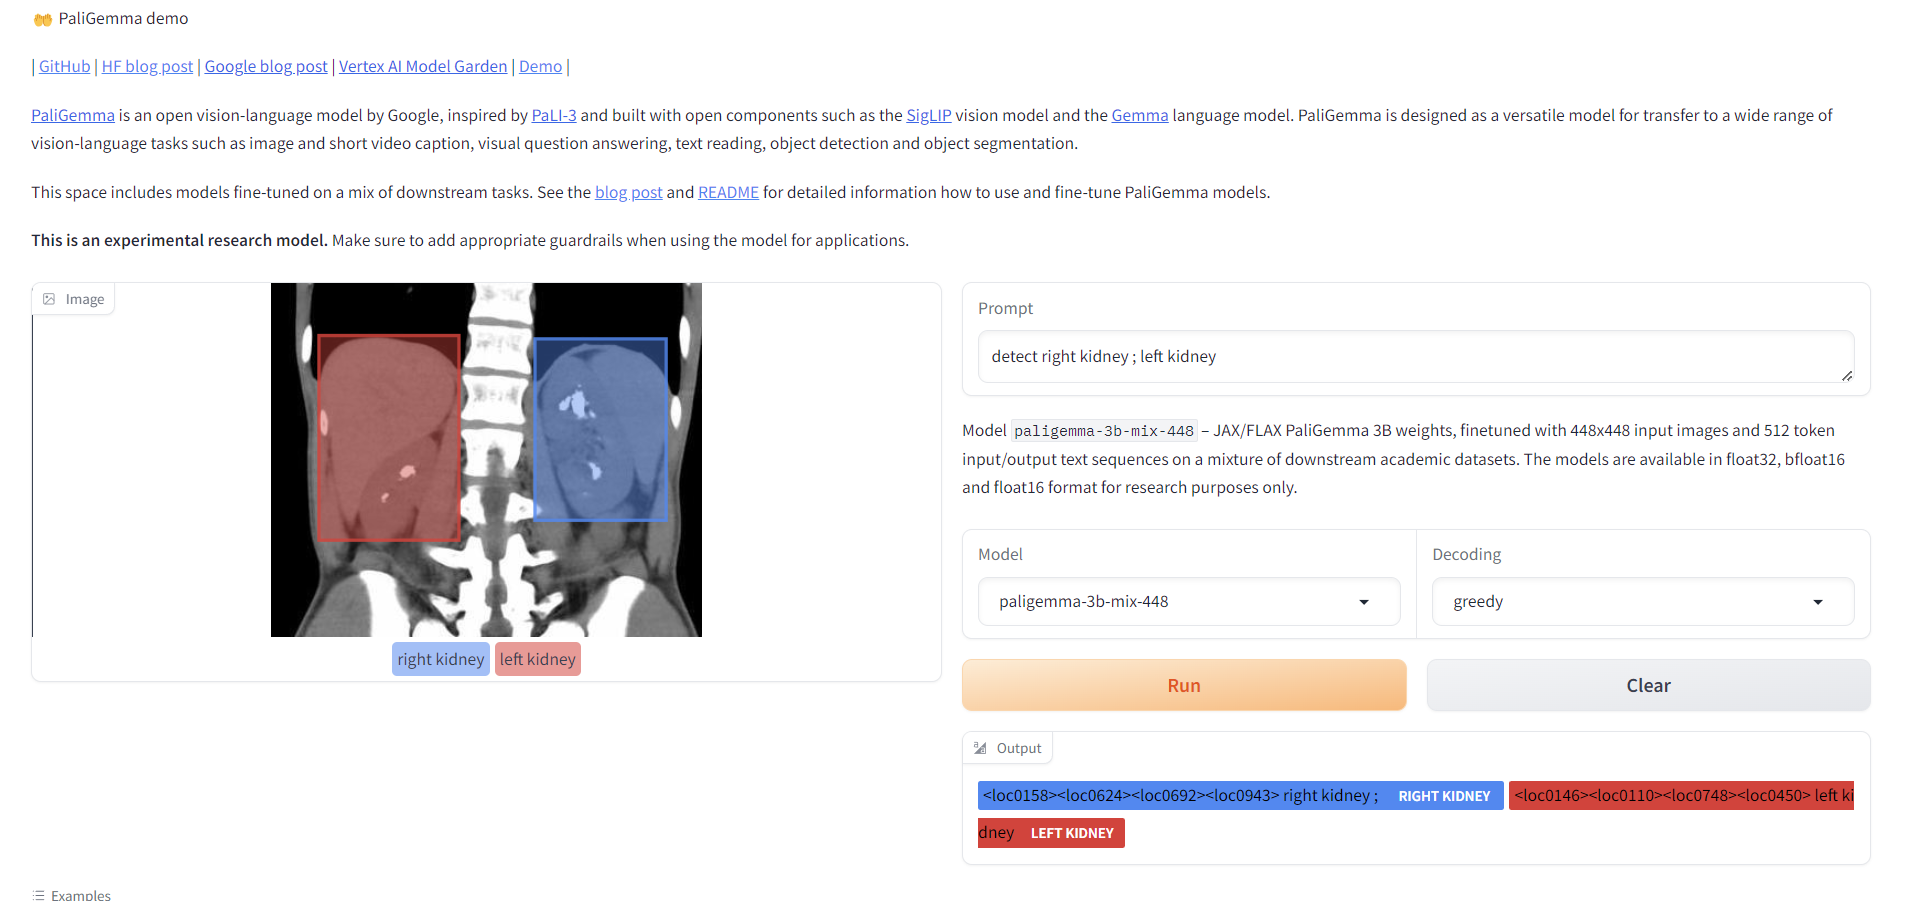

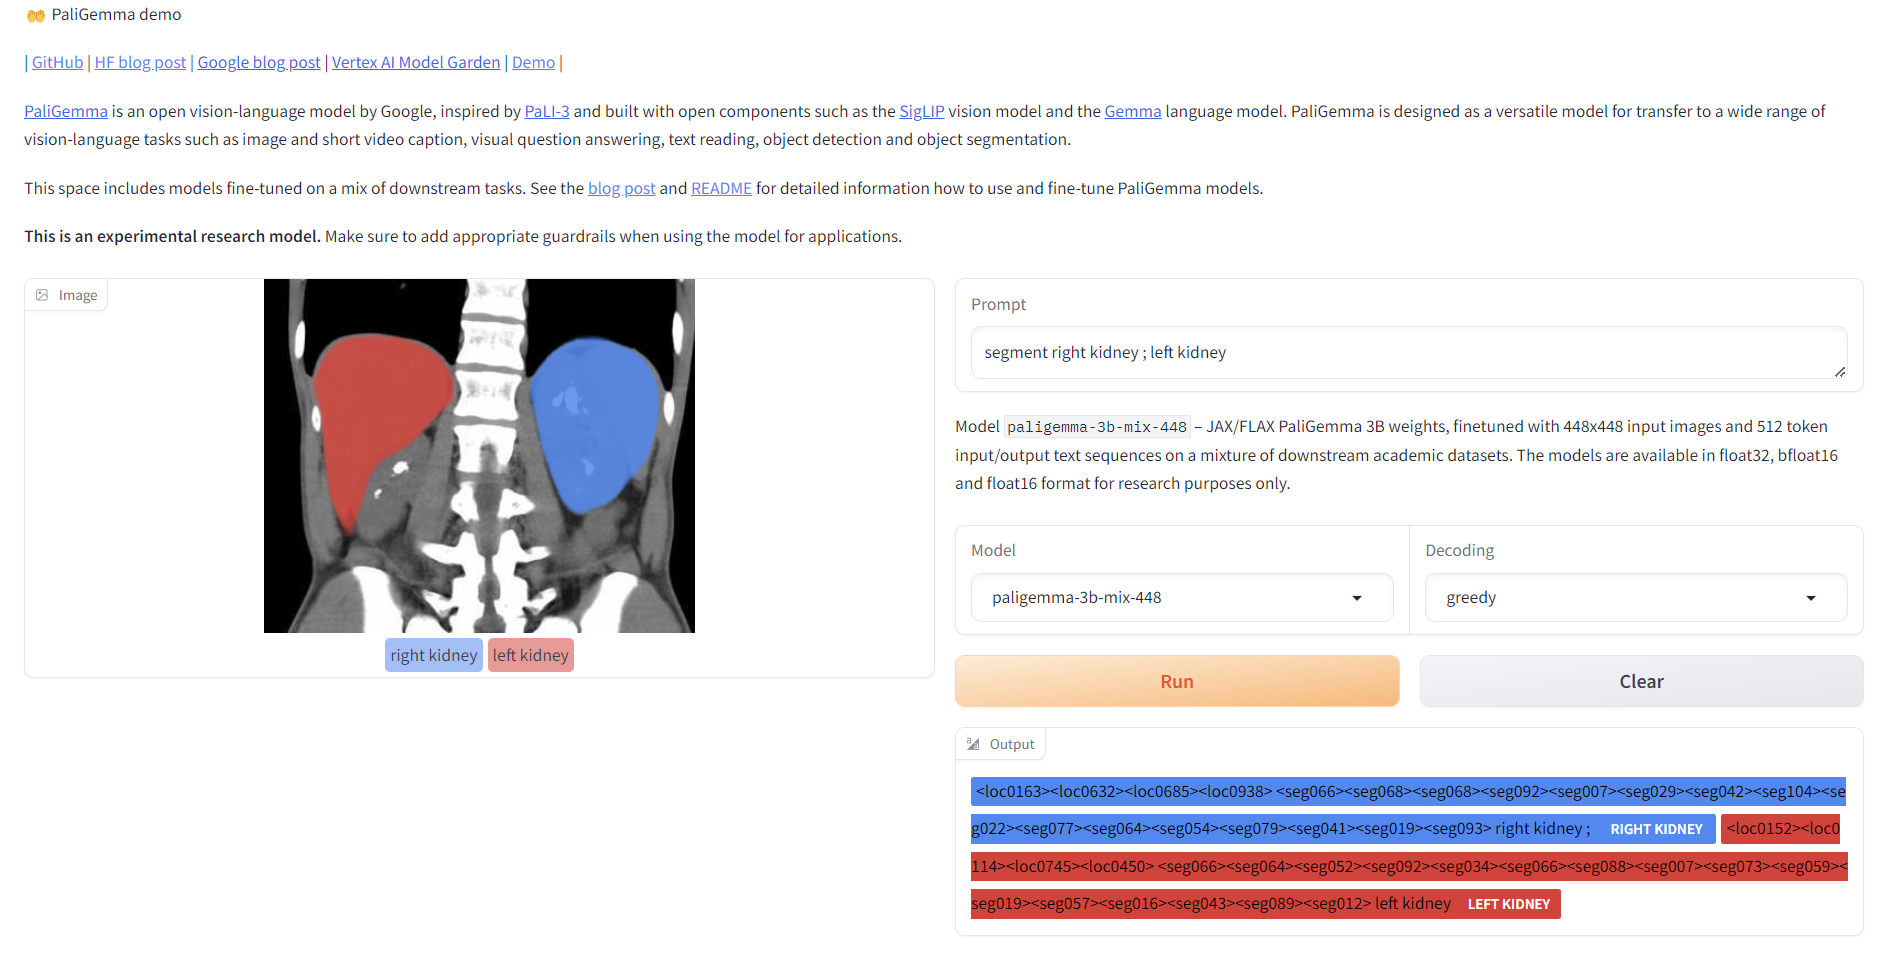

## Paligemma Inference

### Setup Paligemma model

- Load the paligemma model using hf access token
- I have written a custom script to easily looad the model from hf and do single/sliced inference

In [13]:
from src.paligemma.inference import Paligemma

/mnt/ai-storage/pradip/miniconda3/envs/experiment/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
access_token = os.getenv('HF_TOKEN')

In [16]:
paligemma_model = Paligemma(model_id="google/paligemma-3b-mix-448",
                            access_token=access_token)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]


### Single Image inference

- The model is meant to work with resolution 448x448. As our raw images is of similar resolution we can work directly on it. 
- Here we will also explore different prompts i.e. detection and segmentation related.

#### sample-1

In [51]:
raw_image = Image.fromarray(sample_image)
result = paligemma_model.run_inference(raw_image, prompt='segment left kidney ; right kidney')
result

[{'content': '<loc0199><loc0080><loc1023><loc0434> <seg071><seg077><seg052><seg092><seg086><seg092><seg079><seg119><seg021><seg114><seg052><seg120><seg114><seg078><seg039><seg044> left kidney ; ',
  'xyxy': (31, 62, 166, 320),
  'mask': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'name': 'left kidney '},
 {'content': '<loc0148><loc0559><loc1023><loc0938> <seg106><seg075><seg077><seg106><seg104><seg026><seg079><seg086><seg065><seg041><seg064><seg104><seg008><seg114><seg014><seg075> right kidney ; ',
  'xyxy': (213, 46, 358, 320),
  'mask': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 

In [44]:
result[1]['name']

'left kidney'

In [52]:
for obj in result:
    if obj['name'] == 'right kidney ':
        right_kidney_bbox = obj['xyxy']
        right_kidney_mask = obj['mask']
    if obj['name'] == 'left kidney ':
        left_kidney_bbox = obj['xyxy']
        left_kidney_mask = obj['mask']

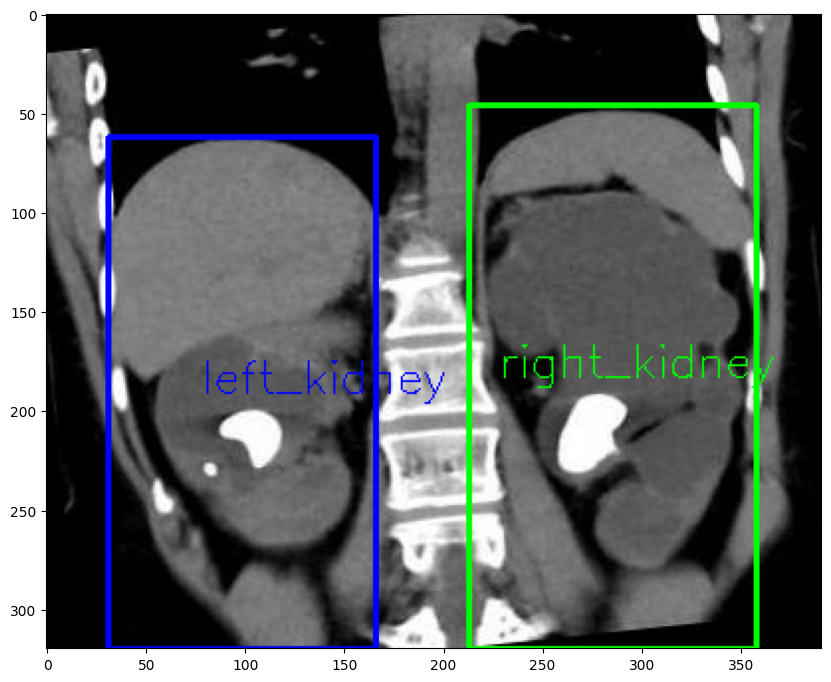

In [64]:
overlay = copy.deepcopy(sample_image)
x1, y1, x2, y2 = left_kidney_bbox
cv2.rectangle(overlay, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2) 
cv2.putText(overlay, f"left_kidney", (int((x1 + x2) // 2.5), int((y1 + y2) // 2)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 1)

x1, y1, x2, y2 = right_kidney_bbox
cv2.rectangle(overlay, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2) 
cv2.putText(overlay, f"right_kidney", (int((x1 + x2) // 2.5), int((y1 + y2) // 2)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 1)

plt.figure(figsize=(10,10))
plt.imshow(overlay)

In [65]:
right_kidney_mask = (right_kidney_mask * 255).astype(np.uint8)
_, binary_mask = cv2.threshold(right_kidney_mask, 127, 255, cv2.THRESH_BINARY)
right_kidney_mask = cv2.merge([binary_mask, binary_mask, binary_mask])

In [68]:
left_kidney_mask = (left_kidney_mask * 255).astype(np.uint8)
_, binary_mask = cv2.threshold(left_kidney_mask, 127, 255, cv2.THRESH_BINARY)
left_kidney_mask = cv2.merge([binary_mask, binary_mask, binary_mask])

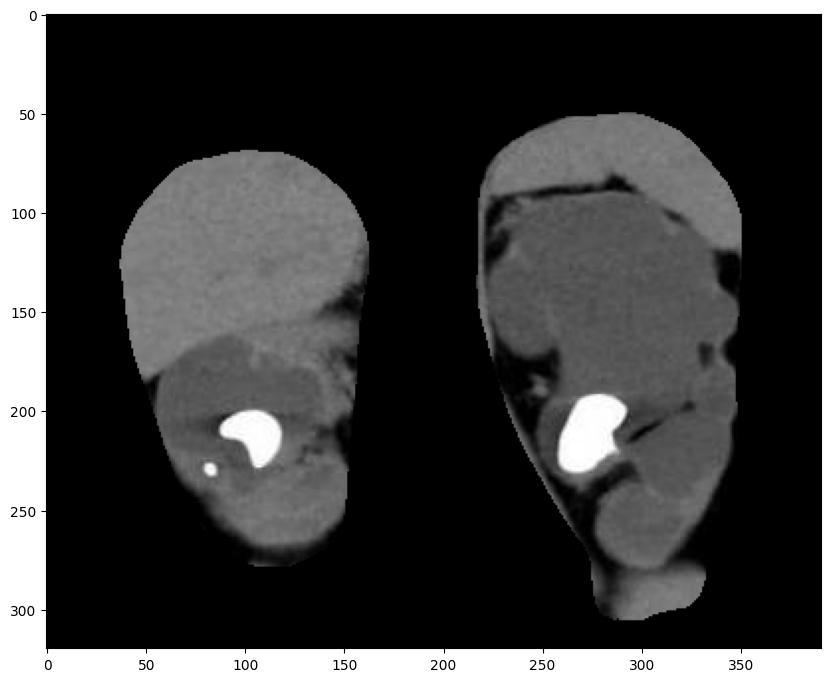

In [70]:
overlay = copy.deepcopy(sample_image)
res = cv2.bitwise_and(overlay, left_kidney_mask+right_kidney_mask)
plt.figure(figsize=(10,10))
plt.imshow(res)

- We see that the mask is not very accurate but PaliGemma shows good potential. 
- With some fine-tuning on annotated datasets paligemmea can give good results on this task. 
- Lets try some other technique

# ClipSeg

In [5]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

/mnt/ai-storage/pradip/miniconda3/envs/experiment/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [11]:
prompts = ["left kidney", "right kidney"]
inputs = processor(text=prompts, images=[sample_image] * len(prompts), padding="max_length", return_tensors="pt")

Unused or unrecognized kwargs: padding.


In [12]:
import torch
import matplotlib.pyplot as plt

In [13]:
# predict
with torch.no_grad():
    outputs = model(**inputs)

preds = outputs.logits.unsqueeze(1)

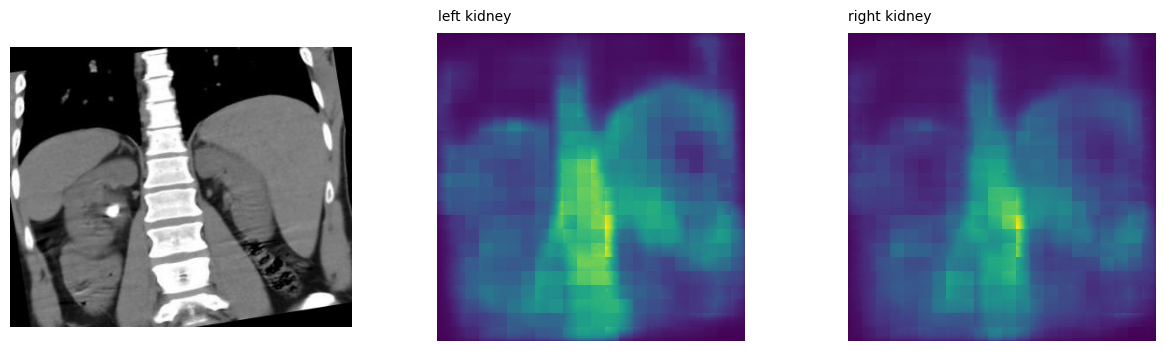

In [19]:
# visualize prediction
_, ax = plt.subplots(1, 3, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(sample_image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(2)];
[ax[i+1].text(0, -15, prompts[i]) for i in range(2)];

- This model does not work and will need further fine-tuning

# Traditional CV

In [64]:
import cv2
import numpy as np
from skimage import exposure
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.morphology import reconstruction as morph_reconstruction
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import remove_small_objects

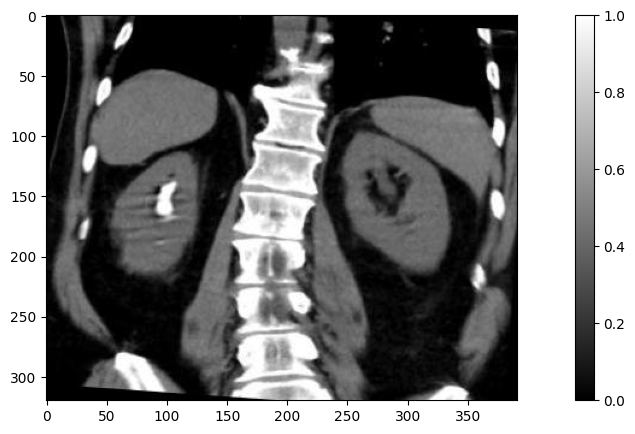

In [201]:
gray = cv2.cvtColor(sample_image, cv2.COLOR_RGB2GRAY)/255
f = plt.figure(figsize=(15, 5), dpi= 100)
plt.imshow(gray, cmap='gray')
plt.colorbar()

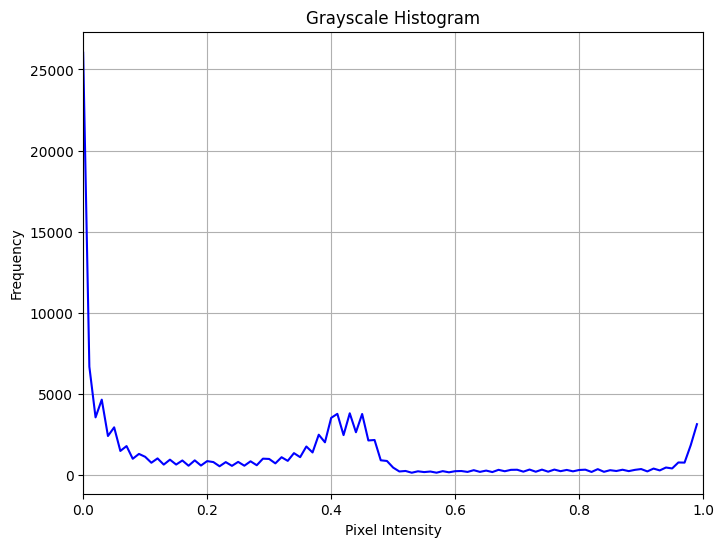

In [202]:
# Step-1: First I can remove the obvious background pixels. For this lets study the pixel distribution

# Calculate the histogram
hist, bins = np.histogram(gray.flatten(), 100, [0, 1])

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.plot(bins[:-1], hist, color='blue', linewidth=1.5)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Grayscale Histogram')
plt.xlim([0, 1])
plt.grid(True)
plt.show()

In [203]:
# From the image I can see that there is a spike in the region 0.3-0.5 which would be our kidney region (best bet).
# lets try to see if we can move closer to getting the mask with this understanding
# we will do morphological reconstruction of the grayscale image

min_val = 0.2
max_val = 0.6
lower_mask = 0.3
higher_marker = 0.45

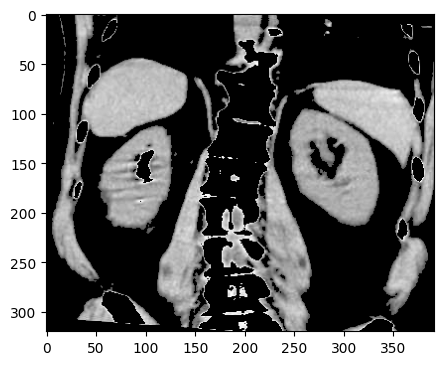

In [204]:
clipped_image = np.clip(gray, min_val, max_val)
clipped_image[(gray < min_val) | (gray > max_val)] = 0
f = plt.figure(figsize=(5, 5), dpi= 100)
plt.imshow(clipped_image, cmap='gray')

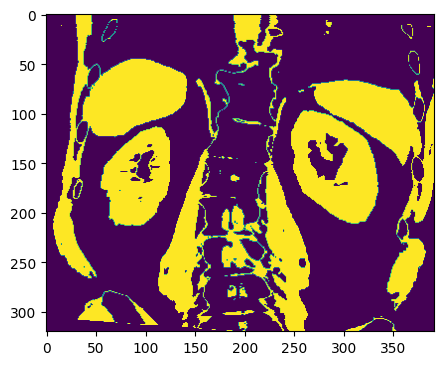

In [205]:
mask = (clipped_image>lower_mask).astype(np.uint8)
f = plt.figure(figsize=(5, 5), dpi= 100)
plt.imshow(mask)

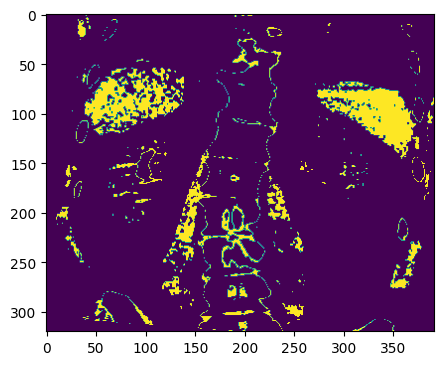

In [206]:
marker = (clipped_image>0.45).astype(np.uint8)
marker = np.where(mask==0,0,marker)
f = plt.figure(figsize=(5, 5), dpi= 100)
plt.imshow(marker)

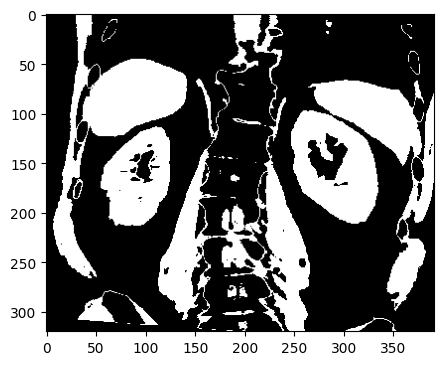

In [207]:
morph_pred = morph_reconstruction(marker, mask)
f = plt.figure(figsize=(5, 5), dpi= 100)
plt.imshow(morph_pred, cmap='gray')

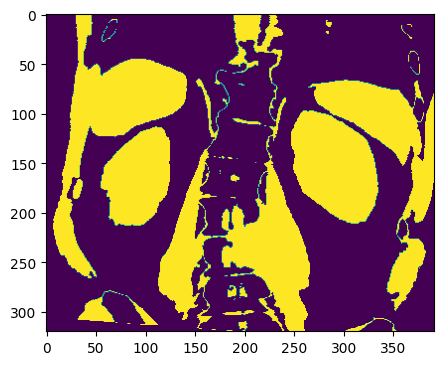

In [212]:
prb_fg = binary_fill_holes(morph_pred)
f = plt.figure(figsize=(5, 5), dpi= 100)
plt.imshow(prb_fg)

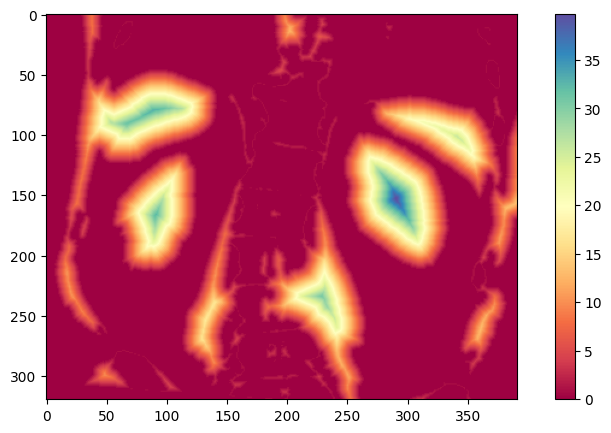

In [214]:
dist_transform = cv2.distanceTransform(prb_fg.astype(np.uint8),cv2.DIST_L2,3)
f = plt.figure(figsize=(10, 5), dpi= 100) 
plt.imshow(dist_transform, "Spectral")
plt.colorbar()

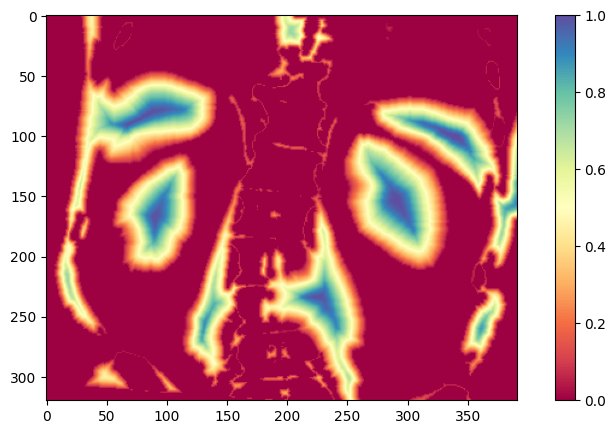

In [216]:
dist_transform = exposure.equalize_adapthist(((dist_transform / dist_transform.max()) * 255).astype('uint8'), 
                                             clip_limit=0.03)
f = plt.figure(figsize=(10, 5), dpi= 100) 
plt.imshow(dist_transform, "Spectral")
plt.colorbar()

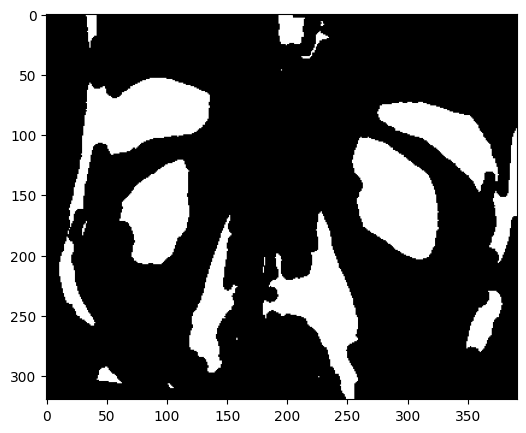

In [218]:
ret, sure_fg = cv2.threshold(dist_transform,0.3*dist_transform.max(),1,0)
f = plt.figure(figsize=(10, 5), dpi= 100)  
plt.imshow(sure_fg, "gray")

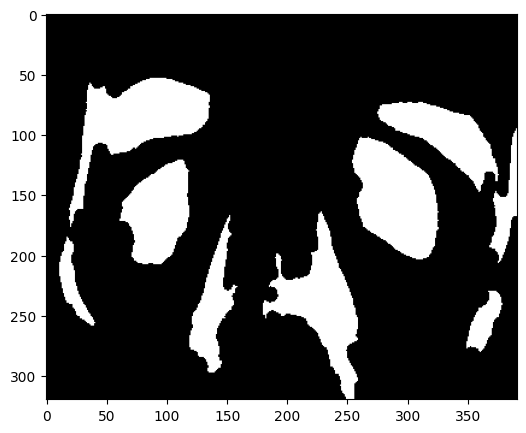

In [219]:
sure_fg = remove_small_objects(sure_fg>0, min_size=500, connectivity=1)
f = plt.figure(figsize=(10, 5), dpi= 100) 
plt.imshow(sure_fg, "gray")

[0 1 2 3 4 5 6 7 8 9]


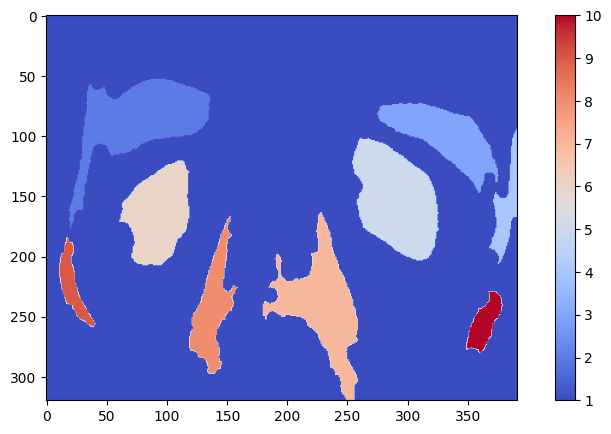

In [234]:
sure_fg = np.uint8(sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
print(np.unique(markers))

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

f = plt.figure(figsize=(10, 5), dpi= 100) 
plt.imshow(markers, cmap="coolwarm")
plt.colorbar()

- The obtained mask can be used with SAM like algorithms to get good kindey segmentation masks. 